In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
import matplotlib.pyplot as plt
from io import StringIO
import seaborn as sns
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
import os
import random
import torch

In [2]:
df = pd.read_csv('johor_senai_weather_data.csv')

In [3]:
df

,date,temp_celsius,temp_fahrenheit,condition,wind_speed_mph,pressure,humidity(%)
0,2014-01-01 00:00:00,23.888889,75,Mostly Cloudy,1,29.74,94
1,2014-01-01 01:00:00,23.888889,75,Mostly Cloudy,2,29.74,94
2,2014-01-01 02:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
3,2014-01-01 03:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
4,2014-01-01 04:00:00,23.888889,75,Mostly Cloudy,1,29.68,94
...,...,...,...,...,...,...,...
95184,2024-09-24 20:00:00,25.000000,77,Fair,2,29.65,94
95185,2024-09-24 21:00:00,25.000000,77,Fair,3,29.68,94
95186,2024-09-24 22:00:00,25.000000,77,Fair,3,29.68,94
95187,2024-09-24 23:00:00,25.000000,77,Fair,1,29.71,94


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95189 entries, 0 to 95188
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             95189 non-null  object 
 1   temp_celsius     95189 non-null  float64
 2   temp_fahrenheit  95189 non-null  int64  
 3   condition        95189 non-null  object 
 4   wind_speed_mph   95189 non-null  int64  
 5   pressure         95189 non-null  float64
 6   humidity(%)      95189 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 5.1+ MB


In [5]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by=['date'],ignore_index=True, inplace=True)
df

,date,temp_celsius,temp_fahrenheit,condition,wind_speed_mph,pressure,humidity(%)
0,2014-01-01 00:00:00,23.888889,75,Mostly Cloudy,1,29.74,94
1,2014-01-01 01:00:00,23.888889,75,Mostly Cloudy,2,29.74,94
2,2014-01-01 02:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
3,2014-01-01 03:00:00,23.888889,75,Mostly Cloudy,1,29.71,94
4,2014-01-01 04:00:00,23.888889,75,Mostly Cloudy,1,29.68,94
...,...,...,...,...,...,...,...
95184,2024-09-24 20:00:00,25.000000,77,Fair,2,29.65,94
95185,2024-09-24 21:00:00,25.000000,77,Fair,3,29.68,94
95186,2024-09-24 22:00:00,25.000000,77,Fair,3,29.68,94
95187,2024-09-24 23:00:00,25.000000,77,Fair,1,29.71,94


In [6]:
unique_categories = df['condition'].unique()
print(unique_categories)

['Mostly Cloudy' 'Partly Cloudy' 'Light Rain Shower' 'Heavy Rain' 'Rain'
 'Light Rain' 'Light Rain with Thunder' 'Fog' 'Thunder' 'T-Storm'
 'Heavy T-Storm' 'Haze' 'Showers in the Vicinity' 'Heavy Rain Shower'
 'Rain Shower' 'Heavy T-Storm / Windy' 'Thunder in the Vicinity' 'Fair'
 'Mostly Cloudy / Windy' 'Rain Shower / Windy' 'Rain and Sleet'
 'Thunder and Hail' 'Mist' 'Rain and Snow']


In [7]:
# Extract additional time features
df['Year'] = df['date'].dt.year
df['Month'] = df['date'].dt.month
df['Day'] = df['date'].dt.day
df['Hour'] = df['date'].dt.hour

In [8]:
df

,date,temp_celsius,temp_fahrenheit,condition,wind_speed_mph,pressure,humidity(%),Year,Month,Day,Hour
0,2014-01-01 00:00:00,23.888889,75,Mostly Cloudy,1,29.74,94,2014,1,1,0
1,2014-01-01 01:00:00,23.888889,75,Mostly Cloudy,2,29.74,94,2014,1,1,1
2,2014-01-01 02:00:00,23.888889,75,Mostly Cloudy,1,29.71,94,2014,1,1,2
3,2014-01-01 03:00:00,23.888889,75,Mostly Cloudy,1,29.71,94,2014,1,1,3
4,2014-01-01 04:00:00,23.888889,75,Mostly Cloudy,1,29.68,94,2014,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...
95184,2024-09-24 20:00:00,25.000000,77,Fair,2,29.65,94,2024,9,24,20
95185,2024-09-24 21:00:00,25.000000,77,Fair,3,29.68,94,2024,9,24,21
95186,2024-09-24 22:00:00,25.000000,77,Fair,3,29.68,94,2024,9,24,22
95187,2024-09-24 23:00:00,25.000000,77,Fair,1,29.71,94,2024,9,24,23


In [9]:
label_encoder = LabelEncoder()
df['condition_encoded'] = label_encoder.fit_transform(df['condition'])
df

,date,temp_celsius,temp_fahrenheit,condition,wind_speed_mph,pressure,humidity(%),Year,Month,Day,Hour,condition_encoded
0,2014-01-01 00:00:00,23.888889,75,Mostly Cloudy,1,29.74,94,2014,1,1,0,11
1,2014-01-01 01:00:00,23.888889,75,Mostly Cloudy,2,29.74,94,2014,1,1,1,11
2,2014-01-01 02:00:00,23.888889,75,Mostly Cloudy,1,29.71,94,2014,1,1,2,11
3,2014-01-01 03:00:00,23.888889,75,Mostly Cloudy,1,29.71,94,2014,1,1,3,11
4,2014-01-01 04:00:00,23.888889,75,Mostly Cloudy,1,29.68,94,2014,1,1,4,11
...,...,...,...,...,...,...,...,...,...,...,...,...
95184,2024-09-24 20:00:00,25.000000,77,Fair,2,29.65,94,2024,9,24,20,0
95185,2024-09-24 21:00:00,25.000000,77,Fair,3,29.68,94,2024,9,24,21,0
95186,2024-09-24 22:00:00,25.000000,77,Fair,3,29.68,94,2024,9,24,22,0
95187,2024-09-24 23:00:00,25.000000,77,Fair,1,29.71,94,2024,9,24,23,0


In [10]:
# Print the mapping between original conditions and encoded values
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping between condition and encoded values:")
print(label_mapping)

Mapping between condition and encoded values:
{'Fair': 0, 'Fog': 1, 'Haze': 2, 'Heavy Rain': 3, 'Heavy Rain Shower': 4, 'Heavy T-Storm': 5, 'Heavy T-Storm / Windy': 6, 'Light Rain': 7, 'Light Rain Shower': 8, 'Light Rain with Thunder': 9, 'Mist': 10, 'Mostly Cloudy': 11, 'Mostly Cloudy / Windy': 12, 'Partly Cloudy': 13, 'Rain': 14, 'Rain Shower': 15, 'Rain Shower / Windy': 16, 'Rain and Sleet': 17, 'Rain and Snow': 18, 'Showers in the Vicinity': 19, 'T-Storm': 20, 'Thunder': 21, 'Thunder and Hail': 22, 'Thunder in the Vicinity': 23}


In [11]:
columns_to_drop = ['date', 'condition', 'condition_encoded']
df_new = df.drop(columns=columns_to_drop)

In [12]:
df_new

,temp_celsius,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Year,Month,Day,Hour
0,23.888889,75,1,29.74,94,2014,1,1,0
1,23.888889,75,2,29.74,94,2014,1,1,1
2,23.888889,75,1,29.71,94,2014,1,1,2
3,23.888889,75,1,29.71,94,2014,1,1,3
4,23.888889,75,1,29.68,94,2014,1,1,4
...,...,...,...,...,...,...,...,...,...
95184,25.000000,77,2,29.65,94,2024,9,24,20
95185,25.000000,77,3,29.68,94,2024,9,24,21
95186,25.000000,77,3,29.68,94,2024,9,24,22
95187,25.000000,77,1,29.71,94,2024,9,24,23


In [13]:
correlation_matrix = df_new[['temp_celsius', 'temp_fahrenheit', 'wind_speed_mph', 
                             'pressure', 'humidity(%)', 'Year', 'Month', 'Day', 'Hour']].corr()

print(correlation_matrix)

                 temp_celsius  temp_fahrenheit  wind_speed_mph  pressure  \
temp_celsius         1.000000         1.000000        0.577808 -0.227575   
temp_fahrenheit      1.000000         1.000000        0.577808 -0.227575   
wind_speed_mph       0.577808         0.577808        1.000000 -0.081263   
pressure            -0.227575        -0.227575       -0.081263  1.000000   
humidity(%)         -0.914988        -0.914988       -0.639317  0.164833   
Year                 0.034270         0.034270        0.026298 -0.087408   
Month               -0.014892        -0.014892       -0.142513 -0.132827   
Day                  0.001266         0.001266        0.005629 -0.004091   
Hour                 0.381426         0.381426        0.302640 -0.175868   

                 humidity(%)      Year     Month       Day      Hour  
temp_celsius       -0.914988  0.034270 -0.014892  0.001266  0.381426  
temp_fahrenheit    -0.914988  0.034270 -0.014892  0.001266  0.381426  
wind_speed_mph     -0.6393

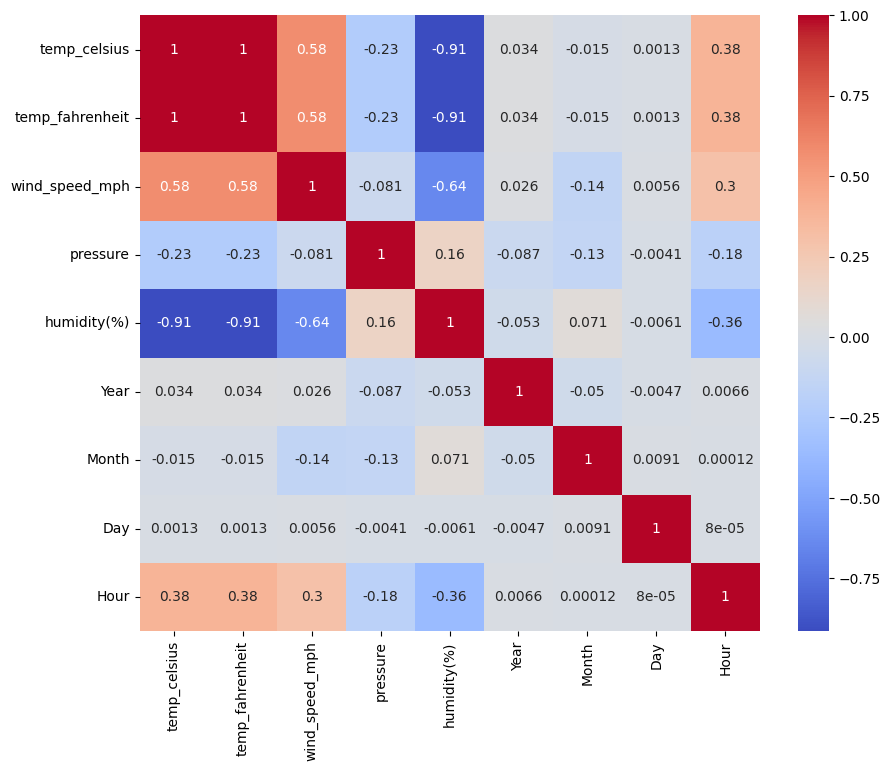

In [14]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [15]:
# Set random seed for reproducibility
random.seed(1)
np.random.seed(1)
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

In [16]:
seq_length = 24  # Change sequence length from 10 to 24

sequences = []
for i in range(len(df) - seq_length):
    sequence = df_new.iloc[i:i+seq_length].values.astype(np.float32)
    sequences.append(sequence)

x = np.array(sequences)
y = df['temp_celsius'].to_numpy()[seq_length:].reshape(-1, 1)  # This now starts at seq_length, which is 24

In [17]:
# Split the data into training, validation, and test sets
train_total = round(len(x) * 70 / 100)
val_total = round(len(x) * 10 / 100)
test_total = round(len(x) * 20 / 100)

In [18]:
test_n_start = train_total + val_total

X_train, y_train = x[:train_total], y[:train_total]
X_val, y_val = x[train_total:test_n_start], y[train_total:test_n_start]
X_test, y_test = x[test_n_start:], y[test_n_start:]

In [19]:
print(f'Train X shape: {X_train.shape}, Train y shape {y_train.shape}')
print(f'Validation X shape: {X_val.shape}, Validation y shape {y_val.shape}')
print(f'Test X shape: {X_test.shape}, Test y shape {y_test.shape}')

Train X shape: (66616, 24, 9), Train y shape (66616, 1)
Validation X shape: (9516, 24, 9), Validation y shape (9516, 1)
Test X shape: (19033, 24, 9), Test y shape (19033, 1)


In [20]:
# Define the LSTM model with Bidirectional layers and Dropout
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # X_train.shape[1] should now be 24
model.add(Bidirectional(LSTM(64, activation='relu')))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[RootMeanSquaredError()])

In [21]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 128)               37888     
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 38017 (148.50 KB)
Trainable params: 38017 (148.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Define the ModelCheckpoint and EarlyStopping callbacks
check_point = ModelCheckpoint('./tmp/checkpoint', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model with the callbacks
history = model.fit(X_train, y_train, epochs=500, batch_size=64, validation_data=(X_val, y_val), callbacks=[check_point, early_stopping])

Epoch 1/500
1037/1041 [============================>.] - ETA: 0s - loss: 155166.0000 - root_mean_squared_error: 393.9112INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 14ms/step - loss: 154721.0781 - root_mean_squared_error: 393.3460 - val_loss: 41214.1992 - val_root_mean_squared_error: 203.0128
Epoch 2/500
1039/1041 [============================>.] - ETA: 0s - loss: 9466.1592 - root_mean_squared_error: 97.2942INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 13ms/step - loss: 9491.5312 - root_mean_squared_error: 97.4245 - val_loss: 33278.4883 - val_root_mean_squared_error: 182.4239
Epoch 3/500
1041/1041 [==============================] - ETA: 0s - loss: 22423.2617 - root_mean_squared_error: 149.7440INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 12ms/step - loss: 22423.2617 - root_mean_squared_error: 149.7440 - val_loss: 5624.5996 - val_root_mean_squared_error: 74.9973
Epoch 4/500
1036/1041 [============================>.] - ETA: 0s - loss: 12702.3096 - root_mean_squared_error: 112.7045INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 12s 12ms/step - loss: 12654.9961 - root_mean_squared_error: 112.4944 - val_loss: 2701.0771 - val_root_mean_squared_error: 51.9719
Epoch 5/500
1038/1041 [============================>.] - ETA: 0s - loss: 5141.1704 - root_mean_squared_error: 71.7020INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 13ms/step - loss: 5128.9629 - root_mean_squared_error: 71.6168 - val_loss: 398.1187 - val_root_mean_squared_error: 19.9529
Epoch 6/500
1041/1041 [==============================] - 11s 10ms/step - loss: 3438.4565 - root_mean_squared_error: 58.6384 - val_loss: 13270.6445 - val_root_mean_squared_error: 115.1983
Epoch 7/500
1041/1041 [==============================] - 11s 10ms/step - loss: 6418.9263 - root_mean_squared_error: 80.1182 - val_loss: 1198.1063 - val_root_mean_squared_error: 34.6137
Epoch 8/500
1041/1041 [==============================] - ETA: 0s - loss: 391.5848 - root_mean_squared_error: 19.7885INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 13ms/step - loss: 391.5848 - root_mean_squared_error: 19.7885 - val_loss: 340.0283 - val_root_mean_squared_error: 18.4399
Epoch 9/500
1039/1041 [============================>.] - ETA: 0s - loss: 275.5068 - root_mean_squared_error: 16.5984INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 13ms/step - loss: 275.4930 - root_mean_squared_error: 16.5980 - val_loss: 236.3387 - val_root_mean_squared_error: 15.3733
Epoch 10/500
1039/1041 [============================>.] - ETA: 0s - loss: 179.8241 - root_mean_squared_error: 13.4099INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 13ms/step - loss: 179.6839 - root_mean_squared_error: 13.4046 - val_loss: 134.3667 - val_root_mean_squared_error: 11.5917
Epoch 11/500
1041/1041 [==============================] - 11s 11ms/step - loss: 116.8020 - root_mean_squared_error: 10.8075 - val_loss: 166.1324 - val_root_mean_squared_error: 12.8892
Epoch 12/500
1041/1041 [==============================] - 11s 11ms/step - loss: 161.5138 - root_mean_squared_error: 12.7088 - val_loss: 159.4078 - val_root_mean_squared_error: 12.6257
Epoch 13/500
1037/1041 [============================>.] - ETA: 0s - loss: 114.3726 - root_mean_squared_error: 10.6945INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 13ms/step - loss: 114.1354 - root_mean_squared_error: 10.6834 - val_loss: 64.6005 - val_root_mean_squared_error: 8.0374
Epoch 14/500
1038/1041 [============================>.] - ETA: 0s - loss: 50.0691 - root_mean_squared_error: 7.0760INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 13ms/step - loss: 50.0586 - root_mean_squared_error: 7.0752 - val_loss: 47.7625 - val_root_mean_squared_error: 6.9110
Epoch 15/500
1037/1041 [============================>.] - ETA: 0s - loss: 35.2177 - root_mean_squared_error: 5.9344INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 13ms/step - loss: 35.2150 - root_mean_squared_error: 5.9342 - val_loss: 37.6053 - val_root_mean_squared_error: 6.1323
Epoch 16/500
1037/1041 [============================>.] - ETA: 0s - loss: 33.0901 - root_mean_squared_error: 5.7524INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 14ms/step - loss: 33.0573 - root_mean_squared_error: 5.7495 - val_loss: 28.0994 - val_root_mean_squared_error: 5.3009
Epoch 17/500
1039/1041 [============================>.] - ETA: 0s - loss: 24.8730 - root_mean_squared_error: 4.9873INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 14ms/step - loss: 24.9009 - root_mean_squared_error: 4.9901 - val_loss: 18.2506 - val_root_mean_squared_error: 4.2721
Epoch 18/500
1041/1041 [==============================] - 11s 11ms/step - loss: 26.1574 - root_mean_squared_error: 5.1144 - val_loss: 30.6898 - val_root_mean_squared_error: 5.5398
Epoch 19/500
1041/1041 [==============================] - 12s 11ms/step - loss: 28.3377 - root_mean_squared_error: 5.3233 - val_loss: 72.8373 - val_root_mean_squared_error: 8.5345
Epoch 20/500
1041/1041 [==============================] - 12s 11ms/step - loss: 149.7116 - root_mean_squared_error: 12.2357 - val_loss: 29.5155 - val_root_mean_squared_error: 5.4328
Epoch 21/500
1041/1041 [==============================] - 12s 11ms/step - loss: 26.2717 - root_mean_squared_error: 5.1256 - val_loss: 19.3950 - val_root_mean_squared_error: 4.4040
Epoch 22/500
1036/1041 [============================>.] - ETA: 0s - loss: 27.0961 - root_mean_squared_error: 5.

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 13s 13ms/step - loss: 27.0471 - root_mean_squared_error: 5.2007 - val_loss: 17.8471 - val_root_mean_squared_error: 4.2246
Epoch 23/500
1037/1041 [============================>.] - ETA: 0s - loss: 16.2864 - root_mean_squared_error: 4.0356INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 13ms/step - loss: 16.2815 - root_mean_squared_error: 4.0350 - val_loss: 12.6273 - val_root_mean_squared_error: 3.5535
Epoch 24/500
1038/1041 [============================>.] - ETA: 0s - loss: 11.5829 - root_mean_squared_error: 3.4034INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 17s 16ms/step - loss: 11.5823 - root_mean_squared_error: 3.4033 - val_loss: 11.2799 - val_root_mean_squared_error: 3.3586
Epoch 25/500
1038/1041 [============================>.] - ETA: 0s - loss: 12.0752 - root_mean_squared_error: 3.4749INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 17s 16ms/step - loss: 12.0640 - root_mean_squared_error: 3.4733 - val_loss: 11.1275 - val_root_mean_squared_error: 3.3358
Epoch 26/500
1041/1041 [==============================] - ETA: 0s - loss: 8.8220 - root_mean_squared_error: 2.9702INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 18s 17ms/step - loss: 8.8220 - root_mean_squared_error: 2.9702 - val_loss: 5.9104 - val_root_mean_squared_error: 2.4311
Epoch 27/500
1038/1041 [============================>.] - ETA: 0s - loss: 6.1989 - root_mean_squared_error: 2.4898INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 18s 17ms/step - loss: 6.1929 - root_mean_squared_error: 2.4886 - val_loss: 4.6574 - val_root_mean_squared_error: 2.1581
Epoch 28/500
1041/1041 [==============================] - 14s 13ms/step - loss: 5.1532 - root_mean_squared_error: 2.2701 - val_loss: 4.7173 - val_root_mean_squared_error: 2.1719
Epoch 29/500
1041/1041 [==============================] - ETA: 0s - loss: 4.9917 - root_mean_squared_error: 2.2342INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 4.9917 - root_mean_squared_error: 2.2342 - val_loss: 3.7649 - val_root_mean_squared_error: 1.9403
Epoch 30/500
1041/1041 [==============================] - 13s 12ms/step - loss: 237.5498 - root_mean_squared_error: 15.4127 - val_loss: 20.7780 - val_root_mean_squared_error: 4.5583
Epoch 31/500
1041/1041 [==============================] - 13s 13ms/step - loss: 12.3072 - root_mean_squared_error: 3.5082 - val_loss: 9.5461 - val_root_mean_squared_error: 3.0897
Epoch 32/500
1041/1041 [==============================] - 13s 13ms/step - loss: 9.5074 - root_mean_squared_error: 3.0834 - val_loss: 9.6979 - val_root_mean_squared_error: 3.1141
Epoch 33/500
1041/1041 [==============================] - 14s 13ms/step - loss: 18.7363 - root_mean_squared_error: 4.3285 - val_loss: 16.7570 - val_root_mean_squared_error: 4.0935
Epoch 34/500
1041/1041 [==============================] - 13s 13ms/step - loss: 48.2877 - root_mean_squared_error: 6

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 5.6284 - root_mean_squared_error: 2.3724 - val_loss: 3.5871 - val_root_mean_squared_error: 1.8940
Epoch 43/500
1041/1041 [==============================] - 12s 12ms/step - loss: 8.8216 - root_mean_squared_error: 2.9701 - val_loss: 3.7996 - val_root_mean_squared_error: 1.9493
Epoch 44/500
1041/1041 [==============================] - 12s 12ms/step - loss: 3.4005 - root_mean_squared_error: 1.8440 - val_loss: 4.9380 - val_root_mean_squared_error: 2.2222
Epoch 45/500
1039/1041 [============================>.] - ETA: 0s - loss: 2.9997 - root_mean_squared_error: 1.7320INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 2.9995 - root_mean_squared_error: 1.7319 - val_loss: 2.5255 - val_root_mean_squared_error: 1.5892
Epoch 46/500
1041/1041 [==============================] - 13s 12ms/step - loss: 2.7948 - root_mean_squared_error: 1.6718 - val_loss: 3.2501 - val_root_mean_squared_error: 1.8028
Epoch 47/500
1041/1041 [==============================] - ETA: 0s - loss: 2.5663 - root_mean_squared_error: 1.6020INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 2.5663 - root_mean_squared_error: 1.6020 - val_loss: 2.1482 - val_root_mean_squared_error: 1.4657
Epoch 48/500
1041/1041 [==============================] - 13s 13ms/step - loss: 2.4851 - root_mean_squared_error: 1.5764 - val_loss: 2.1830 - val_root_mean_squared_error: 1.4775
Epoch 49/500
1041/1041 [==============================] - 13s 13ms/step - loss: 2.4425 - root_mean_squared_error: 1.5628 - val_loss: 3.0171 - val_root_mean_squared_error: 1.7370
Epoch 50/500
1041/1041 [==============================] - ETA: 0s - loss: 2.2001 - root_mean_squared_error: 1.4833INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 2.2001 - root_mean_squared_error: 1.4833 - val_loss: 1.8979 - val_root_mean_squared_error: 1.3777
Epoch 51/500
1037/1041 [============================>.] - ETA: 0s - loss: 2.1324 - root_mean_squared_error: 1.4603INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 15ms/step - loss: 2.1314 - root_mean_squared_error: 1.4599 - val_loss: 1.8047 - val_root_mean_squared_error: 1.3434
Epoch 52/500
1041/1041 [==============================] - 13s 12ms/step - loss: 2.0690 - root_mean_squared_error: 1.4384 - val_loss: 1.8863 - val_root_mean_squared_error: 1.3734
Epoch 53/500
1041/1041 [==============================] - ETA: 0s - loss: 2.0150 - root_mean_squared_error: 1.4195INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 2.0150 - root_mean_squared_error: 1.4195 - val_loss: 1.7949 - val_root_mean_squared_error: 1.3397
Epoch 54/500
1037/1041 [============================>.] - ETA: 0s - loss: 1.8910 - root_mean_squared_error: 1.3752INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.8910 - root_mean_squared_error: 1.3751 - val_loss: 1.7828 - val_root_mean_squared_error: 1.3352
Epoch 55/500
1039/1041 [============================>.] - ETA: 0s - loss: 1.8620 - root_mean_squared_error: 1.3645INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.8614 - root_mean_squared_error: 1.3643 - val_loss: 1.4503 - val_root_mean_squared_error: 1.2043
Epoch 56/500
1041/1041 [==============================] - 13s 12ms/step - loss: 34.3921 - root_mean_squared_error: 5.8645 - val_loss: 4.8917 - val_root_mean_squared_error: 2.2117
Epoch 57/500
1041/1041 [==============================] - 13s 12ms/step - loss: 4.3835 - root_mean_squared_error: 2.0937 - val_loss: 3.9171 - val_root_mean_squared_error: 1.9792
Epoch 58/500
1041/1041 [==============================] - 12s 12ms/step - loss: 3.0956 - root_mean_squared_error: 1.7594 - val_loss: 2.4331 - val_root_mean_squared_error: 1.5598
Epoch 59/500
1041/1041 [==============================] - 13s 12ms/step - loss: 2.1179 - root_mean_squared_error: 1.4553 - val_loss: 1.9101 - val_root_mean_squared_error: 1.3821
Epoch 60/500
1041/1041 [==============================] - 13s 12ms/step - loss: 2.0155 - root_mean_squared_error: 1.4197 -

INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.6724 - root_mean_squared_error: 1.2932 - val_loss: 1.4114 - val_root_mean_squared_error: 1.1880
Epoch 68/500
1039/1041 [============================>.] - ETA: 0s - loss: 1.6001 - root_mean_squared_error: 1.2650INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 1.5995 - root_mean_squared_error: 1.2647 - val_loss: 1.3467 - val_root_mean_squared_error: 1.1605
Epoch 69/500
1038/1041 [============================>.] - ETA: 0s - loss: 1.5587 - root_mean_squared_error: 1.2485INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.5578 - root_mean_squared_error: 1.2481 - val_loss: 1.3238 - val_root_mean_squared_error: 1.1506
Epoch 70/500
1041/1041 [==============================] - 13s 12ms/step - loss: 1.5725 - root_mean_squared_error: 1.2540 - val_loss: 1.5530 - val_root_mean_squared_error: 1.2462
Epoch 71/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.4621 - root_mean_squared_error: 1.2092 - val_loss: 1.8477 - val_root_mean_squared_error: 1.3593
Epoch 72/500
1041/1041 [==============================] - ETA: 0s - loss: 1.4718 - root_mean_squared_error: 1.2132INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 15ms/step - loss: 1.4718 - root_mean_squared_error: 1.2132 - val_loss: 1.1720 - val_root_mean_squared_error: 1.0826
Epoch 73/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.4394 - root_mean_squared_error: 1.1997 - val_loss: 1.9990 - val_root_mean_squared_error: 1.4139
Epoch 74/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.4223 - root_mean_squared_error: 1.1926 - val_loss: 2.0859 - val_root_mean_squared_error: 1.4443
Epoch 75/500
1039/1041 [============================>.] - ETA: 0s - loss: 1.3395 - root_mean_squared_error: 1.1574INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.3390 - root_mean_squared_error: 1.1571 - val_loss: 1.0365 - val_root_mean_squared_error: 1.0181
Epoch 76/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.3738 - root_mean_squared_error: 1.1721 - val_loss: 1.0601 - val_root_mean_squared_error: 1.0296
Epoch 77/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.3571 - root_mean_squared_error: 1.1649 - val_loss: 1.3394 - val_root_mean_squared_error: 1.1573
Epoch 78/500
1041/1041 [==============================] - ETA: 0s - loss: 1.4035 - root_mean_squared_error: 1.1847INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 15s 14ms/step - loss: 1.4035 - root_mean_squared_error: 1.1847 - val_loss: 0.9852 - val_root_mean_squared_error: 0.9926
Epoch 79/500
1041/1041 [==============================] - 13s 13ms/step - loss: 1.2904 - root_mean_squared_error: 1.1359 - val_loss: 1.4875 - val_root_mean_squared_error: 1.2196
Epoch 80/500
1041/1041 [==============================] - 13s 12ms/step - loss: 1.3190 - root_mean_squared_error: 1.1485 - val_loss: 1.1495 - val_root_mean_squared_error: 1.0722
Epoch 81/500
1041/1041 [==============================] - 13s 12ms/step - loss: 1.2465 - root_mean_squared_error: 1.1165 - val_loss: 2.0711 - val_root_mean_squared_error: 1.4391
Epoch 82/500
1041/1041 [==============================] - ETA: 0s - loss: 1.3516 - root_mean_squared_error: 1.1626INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 16s 15ms/step - loss: 1.3516 - root_mean_squared_error: 1.1626 - val_loss: 0.9545 - val_root_mean_squared_error: 0.9770
Epoch 83/500
1037/1041 [============================>.] - ETA: 0s - loss: 1.2274 - root_mean_squared_error: 1.1079INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 14ms/step - loss: 1.2278 - root_mean_squared_error: 1.1080 - val_loss: 0.9354 - val_root_mean_squared_error: 0.9671
Epoch 84/500
1041/1041 [==============================] - 12s 11ms/step - loss: 1.2595 - root_mean_squared_error: 1.1223 - val_loss: 0.9988 - val_root_mean_squared_error: 0.9994
Epoch 85/500
1041/1041 [==============================] - 12s 11ms/step - loss: 1.2207 - root_mean_squared_error: 1.1049 - val_loss: 1.2249 - val_root_mean_squared_error: 1.1068
Epoch 86/500
1041/1041 [==============================] - 12s 11ms/step - loss: 1.1994 - root_mean_squared_error: 1.0952 - val_loss: 1.8416 - val_root_mean_squared_error: 1.3571
Epoch 87/500
1041/1041 [==============================] - ETA: 0s - loss: 1.2337 - root_mean_squared_error: 1.1107INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


INFO:tensorflow:Assets written to: ./tmp\checkpoint\assets


1041/1041 [==============================] - 14s 14ms/step - loss: 1.2337 - root_mean_squared_error: 1.1107 - val_loss: 0.8992 - val_root_mean_squared_error: 0.9482
Epoch 88/500
1041/1041 [==============================] - 12s 11ms/step - loss: 1.2558 - root_mean_squared_error: 1.1206 - val_loss: 1.0485 - val_root_mean_squared_error: 1.0240
Epoch 89/500
1041/1041 [==============================] - 12s 11ms/step - loss: 9.7527 - root_mean_squared_error: 3.1229 - val_loss: 1.8054 - val_root_mean_squared_error: 1.3437
Epoch 90/500
1041/1041 [==============================] - 12s 11ms/step - loss: 2.1902 - root_mean_squared_error: 1.4799 - val_loss: 1.5088 - val_root_mean_squared_error: 1.2283
Epoch 91/500
1041/1041 [==============================] - 12s 12ms/step - loss: 1.2666 - root_mean_squared_error: 1.1254 - val_loss: 1.0935 - val_root_mean_squared_error: 1.0457
Epoch 92/500
1041/1041 [==============================] - 12s 11ms/step - loss: 1.2186 - root_mean_squared_error: 1.1039 - 

In [23]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')

595/595 [==============================] - 2s 3ms/step - loss: 0.8754 - root_mean_squared_error: 0.9356
Test Loss: [0.8753836750984192, 0.9356194138526917]


In [24]:
# Predict on the test data
y_pred = model.predict(X_test, verbose=1)

# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred)
print(f'R-squared Score: {r2}')

595/595 [==============================] - 2s 3ms/step
Mean Squared Error: 0.8753839159143876
Mean Absolute Error: 0.6945069270286323
R-squared Score: 0.8921417591393814


In [25]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 0.9356195358768369


In [26]:
X_test.shape

(19033, 24, 9)

In [27]:
# Make predictions
predictions = model.predict(X_test)
predictions

595/595 [==============================] - 2s 3ms/step


array([[23.853918],
       [23.780584],
       [23.825888],
       ...,
       [24.527517],
       [24.921774],
       [24.975592]], dtype=float32)

In [28]:
y_test

array([[23.88888889],
       [23.88888889],
       [23.88888889],
       ...,
       [25.        ],
       [25.        ],
       [25.        ]])

In [29]:
X_test[1]

array([[2.5000000e+01, 7.7000000e+01, 1.0000000e+00, 2.9680000e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        4.0000000e+00],
       [2.5000000e+01, 7.7000000e+01, 1.0000000e+00, 2.9680000e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        5.0000000e+00],
       [2.5000000e+01, 7.7000000e+01, 1.0000000e+00, 2.9680000e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        6.0000000e+00],
       [2.5000000e+01, 7.7000000e+01, 2.0000000e+00, 2.9709999e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        7.0000000e+00],
       [2.5000000e+01, 7.7000000e+01, 1.0000000e+00, 2.9709999e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        8.0000000e+00],
       [2.6111111e+01, 7.9000000e+01, 1.0000000e+00, 2.9740000e+01,
        9.4000000e+01, 2.0220000e+03, 9.0000000e+00, 8.0000000e+00,
        9.0000000e+00],
       [2.7222221e+01, 8.1000000e+01, 2.

In [34]:
# Create a DataFrame to compare actual and predicted values
comparison_df = pd.DataFrame({
    'Actual Temperature (Normalized)': y_test.flatten(),  # Flatten to 1D for DataFrame
    'Predicted Temperature (Normalized)': y_pred.flatten()
})

# Display the first few rows of the comparison
print(comparison_df.head())

   Actual Temperature (Normalized)  Predicted Temperature (Normalized)
0                        23.888889                           23.853918
1                        23.888889                           23.780584
2                        23.888889                           23.825888
3                        23.888889                           23.763998
4                        23.888889                           23.581900


In [30]:
new_df = df_new.iloc[test_n_start:].copy()  # Use the test set indices only
new_df = new_df.iloc[:len(predictions)]  # Ensure new_df has the same length as predictions
new_df["temp_pred"] = predictions
new_df["date"] = pd.to_datetime(new_df[['Year', 'Month', 'Day', 'Hour']])
new_df

,temp_celsius,temp_fahrenheit,wind_speed_mph,pressure,humidity(%),Year,Month,Day,Hour,temp_pred,date
76132,25.000000,77,3,29.68,94,2022,9,8,3,23.853918,2022-09-08 03:00:00
76133,25.000000,77,1,29.68,94,2022,9,8,4,23.780584,2022-09-08 04:00:00
76134,25.000000,77,1,29.68,94,2022,9,8,5,23.825888,2022-09-08 05:00:00
76135,25.000000,77,1,29.68,94,2022,9,8,6,23.763998,2022-09-08 06:00:00
76136,25.000000,77,2,29.71,94,2022,9,8,7,23.581900,2022-09-08 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...
95160,25.000000,77,1,29.71,89,2024,9,24,0,24.917669,2024-09-24 00:00:00
95161,25.000000,77,1,29.68,89,2024,9,24,1,25.182287,2024-09-24 01:00:00
95162,23.888889,75,1,29.65,100,2024,9,24,2,24.527517,2024-09-24 02:00:00
95163,23.888889,75,1,29.65,100,2024,9,24,3,24.921774,2024-09-24 03:00:00


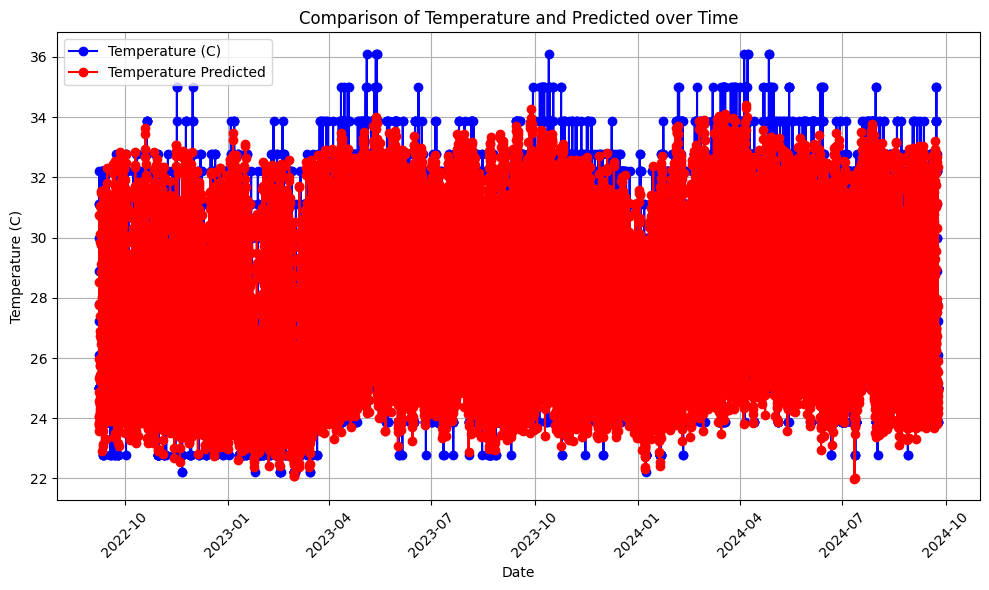

In [31]:
# Plotting with different colors

# Filter the dataframe for the specific year and month
df_specific_month = new_df
plt.figure(figsize=(10, 6))
plt.plot(df_specific_month['date'], df_specific_month['temp_celsius'], marker='o', linestyle='-', color='blue', label='Temperature (C)')
plt.plot(df_specific_month['date'], df_specific_month['temp_pred'], marker='o', linestyle='-', color='red', label='Temperature Predicted')
plt.title('Comparison of Temperature and Predicted over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

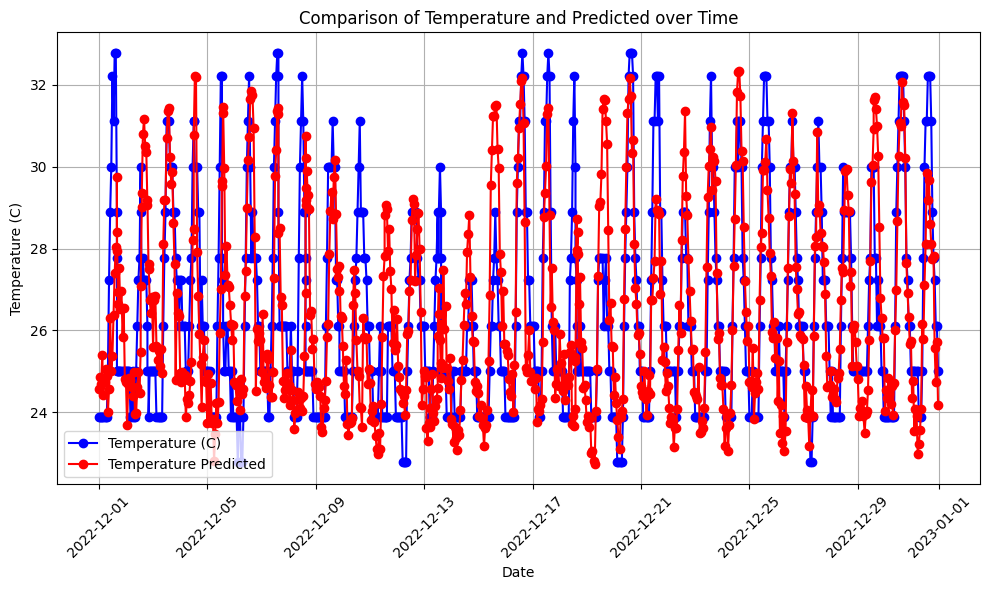

In [32]:
# Plotting with different colors
specific_year = 2022
specific_month = 12  # May

# Filter the dataframe for the specific year and month
df_specific_month = new_df[(new_df['date'].dt.year == specific_year)
                       & (new_df['date'].dt.month == specific_month)]
plt.figure(figsize=(10, 6))
plt.plot(df_specific_month['date'], df_specific_month['temp_celsius'], marker='o', linestyle='-', color='blue', label='Temperature (C)')
plt.plot(df_specific_month['date'], df_specific_month['temp_pred'], marker='o', linestyle='-', color='red', label='Temperature Predicted')
plt.title('Comparison of Temperature and Predicted over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
# Save the Keras model
model.save('lstm_model_weather_24seq.h5')


C:\Users\Nitro 5\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model('lstm_model_weather_24seq.h5')

# Now the loaded_model is ready for predictions or further training
